In [ ]:
# Date: 20.3.2023
# Author: Antti Kiviaho
#
# Notebook for analysing and visualizing visium data after copy number variation, single cell mapping and clustering
# analyses. This is the main results notebook

## Packages and data download

In [2]:
import os 
os.chdir('/lustre/scratch/kiviaho/prostate_spatial/')

import scanpy as sc
import numpy as np
import squidpy as sq
import pandas as pd
import anndata as ad

#from cell2location.utils import select_slide
#from cell2location.plt import plot_spatial

import matplotlib.pyplot as plt
from scripts.utils import load_from_pickle, get_sample_ids
import matplotlib as mpl

import seaborn as sns
sns.set_theme()

sc.set_figure_params(figsize=(6,6),dpi_save=300,frameon=True,format='pdf')

import warnings
warnings.filterwarnings("ignore")


In [3]:
# Download data and format cell2location mapping results into obs columns in both aggregated adata and individual slides
#c2l-results/cell2location_map_20230322/
adata_vis = sc.read_h5ad('./visium_adata_with_c2l_mapping_20230519.h5ad')

adata_vis.obs.joint_leiden_clusters = adata_vis.obs.sample_id.astype(str) + '_' + adata_vis.obs.joint_leiden_clusters.astype(str)
adata_vis.obs['joint_leiden_clusters'] = pd.Categorical(adata_vis.obs['joint_leiden_clusters'])


adata_slides = load_from_pickle('./data/individual_sections_normalized_clustered.pickle')
samples = get_sample_ids()

# Copy obsm (cell2location results) to adata object obs
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

# Copy obsm (cell2location results) to individual slides
for sample in samples:
    vis_subset = adata_vis[adata_vis.obs['sample_id']==sample]
    
    if (vis_subset.obs_names == adata_slides[sample].obs_names).all():
        adata_slides[sample].obsm = vis_subset.obsm.copy()
        
        # add 5% quantile, representing confident cell abundance, 'at least this amount is present',
        # to adata.obs with nice names for plotting
        adata_slides[sample].uns['mod'] = vis_subset.uns['mod'].copy()
        adata_slides[sample].obs[adata_slides[sample].uns['mod']['factor_names']] = adata_slides[sample].obsm['q05_cell_abundance_w_sf']


## Nuclei counting breakdown

In [13]:
# Looking at segmentation-based nuclei counts
nuclei_counts = load_from_pickle('visium_slide_nuclei_counts.pickle')
nuclei_counts['n_nuclei'] = nuclei_counts['n_nuclei'].astype(int)
nuclei_counts['n_nuclei'].describe()

count    32664.000000
mean        21.199731
std         11.605211
min          1.000000
25%         12.000000
50%         21.000000
75%         29.000000
max        100.000000
Name: n_nuclei, dtype: float64

In [14]:
meta = adata_vis.obs.copy()
meta = pd.merge(meta,nuclei_counts,left_index=True,right_index=True,how='left')
if (meta.index == adata_vis.obs.index).all():
    adata_vis.obs = meta
    print('merged!')
adata_vis.obs

merged!


,in_tissue,array_row,array_col,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,...,regulatory T cells,stressed T cells,stressed epithelium,stressed fibroblasts,stressed myeloids,tumor inflammatory monocytes,inferred_cell_counts,pxl_col,pxl_row,n_nuclei
BPH_651_AAACAGCTTTCAGAAG-1,1,43,9,1418,7.257708,2384.0,7.776954,24.370805,33.431208,44.127517,...,0.026759,0.007447,0.000948,0.007155,0.002958,0.014131,8.0,11531,17187,26
BPH_651_AAACAGGGTCTATATT-1,1,47,13,1851,7.524021,3331.0,8.111328,21.645152,30.681477,41.519063,...,0.461684,0.020311,0.004178,0.013477,0.008809,0.007400,11.0,12320,16736,11
BPH_651_AAACATTTCCCGGATT-1,1,61,97,2338,7.757479,4896.0,8.496378,22.058824,31.964869,42.299837,...,0.301918,0.019191,0.001646,0.020140,0.008298,0.439283,13.0,15100,7235,17
BPH_651_AAACCGGGTAGGTACC-1,1,42,28,2186,7.690286,4391.0,8.387540,22.455022,31.906172,42.928718,...,0.095176,0.025277,0.002252,0.006738,0.017225,0.024830,14.0,11339,15036,18
BPH_651_AAACCGTTCGTCCAGG-1,1,52,42,3253,8.087640,8271.0,9.020632,23.431266,34.880909,45.327046,...,1.422114,0.045522,0.020080,0.045281,0.013881,0.107602,19.0,13313,13456,56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CRPC_531_TTGTGGCCCTGACAGT-1,1,18,60,2306,7.743703,4362.0,8.380916,19.899129,28.885832,39.202201,...,0.002860,0.000552,0.000920,0.000606,0.003021,0.000502,2.0,6354,15936,13
CRPC_531_TTGTGGTGGTACTAAG-1,1,63,95,518,6.251904,735.0,6.601230,32.653061,43.129252,56.734694,...,0.007399,0.001230,0.000497,0.003272,0.001178,0.008399,3.0,15225,12011,16
CRPC_531_TTGTTAGCAAATTCGA-1,1,22,42,5193,8.555259,14470.0,9.579902,15.210781,22.722875,31.665515,...,0.013065,0.000347,0.000279,0.000186,0.000188,0.001149,2.0,7133,17975,24
CRPC_531_TTGTTCAGTGTGCTAC-1,1,24,64,1345,7.204893,2063.0,7.632401,20.164809,28.502181,39.263209,...,0.008309,0.001909,0.000296,0.011228,0.001863,0.033079,4.0,7536,15488,12


In [15]:
# Plot the correlation between number of detected UMIs and cells
corr = meta[['total_counts','n_nuclei']].corr(method='pearson')


In [16]:
for s in samples:
    subset = meta[meta['sample_id'] == s]
    corr = subset[['total_counts','n_nuclei']].corr(method='pearson').iloc[0,1]
    print('Sample ' + s)
    print(subset['n_nuclei'].describe())
    print('Pearson correlation between n UMIs and nuclei: {:.3f}'.format(corr))
    print('')

Sample BPH_651
count    2020.000000
mean       21.981683
std        12.695589
min         1.000000
25%        12.000000
50%        20.000000
75%        30.000000
max        80.000000
Name: n_nuclei, dtype: float64
Pearson correlation between n UMIs and nuclei: 0.454

Sample BPH_665
count    4190.000000
mean       14.264200
std         9.150561
min         1.000000
25%         7.000000
50%        13.000000
75%        19.000000
max        79.000000
Name: n_nuclei, dtype: float64
Pearson correlation between n UMIs and nuclei: 0.524

Sample BPH_688
count    1302.000000
mean       16.406298
std        13.125776
min         1.000000
25%         7.000000
50%        13.000000
75%        23.000000
max        87.000000
Name: n_nuclei, dtype: float64
Pearson correlation between n UMIs and nuclei: 0.427

Sample PC-03-6712
count    1775.000000
mean       24.242254
std         9.010949
min         1.000000
25%        18.000000
50%        25.000000
75%        30.000000
max        65.000000
Name: n_nu

## Looking at T-cell receptor subunit coverage across the visium slides (Alfonso)

In [ ]:
import numpy as np

samples = get_sample_ids()
cd3_genes = ['CD3D','CD3E','CD3G','CD247']
n_rows = 1  # Set the number of rows and columns for the subplots
n_cols = len(cd3_genes)

for s in samples:
    adata = adata_vis[adata_vis.obs['sample_id'] == s]

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 3))  # Create the figure with subplots
    fig.suptitle(s) 

    for i, g in enumerate(cd3_genes):
        if g in list(adata.var.index):
            gene_expr = adata[:,g].layers['counts'].toarray().ravel()
            gene_expr = gene_expr[gene_expr != 0]  # Exclude 0 values
            bins = np.arange(1, 11) - 0.5  # Define bins to center histogram bars on integer values
            axs[i].hist(gene_expr, bins=bins)
            axs[i].set_xticks(np.arange(1, 11))  # Set x-axis ticks from 1 to 10
            axs[i].set_xlabel(g+' expression')
            axs[i].set_ylabel('Frequency')

    plt.show()


In [ ]:
# This code will create a 5 by 5 inches axis for each plot, 
# save them in plots/c2l_mapping_results_20230511/ with a 
# sample-specific filename, and set the dpi to 300.
cd3_genes = ['CD3D','CD3E','CD247']
#samples = [s for s in samples if 'CRPC' in s]
import os
for sample in samples:
    slide = adata_slides[sample].copy()
    slide.obs['CD3_sum'] = np.sum(slide[:,cd3_genes].layers['counts'].todense(),axis=1).flatten().tolist()[0]

    # import matplotlib library
    import matplotlib.pyplot as plt
    from matplotlib.backends.backend_pdf import PdfPages

    # set figure axis size and dpi
    fig, ax = plt.subplots(figsize=(3, 3), dpi=100)

    # create spatial plot
    sc.pl.spatial(slide, cmap='viridis',
            # show first 8 cell types
            color='CD3_sum',size=1.3,alpha_img=0.8,
            vmin=0, vmax=6, ax=ax, show=False, title=sample)

    # create filename with sample name
    filename = 'plots/c2l_mapping_results_20230511/cd3_expression/' + sample + '_spatial_cd3_sum_plot.pdf'

    # create output folder if it doesn't exist
    if not os.path.exists(os.path.dirname(filename)):
        os.makedirs(os.path.dirname(filename))

    # save plot to pdf with filename
    with PdfPages(filename) as pdf:
        pdf.savefig(fig)




## Visium mapping plots

In [ ]:
# Plots and saves top n_types with highest prevelance on visium slides
n_types = 12

for sample in samples:
    slide = adata_slides[sample]
    # Subset to only plot the cell types with highest mean prevalence
    cell_types = slide.obs.iloc[:,16:].mean(axis=0).sort_values(ascending=False)[:n_types]

    # plot in spatial coordinates
    with mpl.rc_context({'axes.facecolor':  'black',
                        'figure.figsize': [4.5, 5]}):

        sc.pl.spatial(slide, cmap='magma',
                    # show first 8 cell types
                    color=cell_types.index,
                    ncols=4, size=1.3,alpha_img=0.8,
                    # limit color scale at 99.2% quantile of cell abundance
                    vmin=0, vmax='p99.2', show=False
                    )
        plt.savefig('./plots/c2l_mapping_results_20230519/'+sample+'_c2l_mapping_top12_abundant.png',dpi=200)
        plt.clf()

In [ ]:
## Side by side violin plots of abundant cell types + spatial 

plt.rcParams.update({'axes.titlesize': 'small'})

n_types = 6
obs_name = 'joint_leiden_clusters'

for s in samples:

    slide = adata_slides[s]

    # Subset to only plot the cell types with highest mean prevalence
    cell_types = slide.obs.iloc[:,16:].mean(axis=0).sort_values(ascending=False)[:n_types].index

    fig = plt.figure(figsize=(12,12))

    gs = fig.add_gridspec(6,3)
    ax6 = fig.add_subplot(gs[:, 1:3])

    # Plot the data in the left column subplots
    for i in range(6):

        ax_plotting = fig.add_subplot(gs[i,0])

        sc.pl.violin(slide,groupby=obs_name,keys=cell_types[i],jitter=False,rotation=45,inner='box',
                    ax=ax_plotting,show=False)
        
        ax_plotting.yaxis.label.set_size(12)
        #ax_plotting.yaxis.label.set_rotation('horizontal')

        if i < 5:  # only remove x-labels for the top 5 subplots on the left
            ax_plotting.tick_params(axis='x', which='both', bottom=False, labelbottom=False) 

    sc.pl.spatial(adata_slides[s],color='joint_leiden_clusters',size=1.3,ax=ax6)

    fig.savefig('./plots/c2l_mapping_results_20230519/'+s+'_cell_type_prevalences_per_cluster.png')
    fig.clf()



## Seconary analysis of the cell type mapping numbers

In [4]:
# Creating an anndata-structure for inferred cell numbers

# Filters if necessary
ctypes = adata_vis.uns['mod']['factor_names']
#ctypes = [ctype for ctype in ctypes if 'epithelial' in ctype or 'fibroblast' in ctype]

cell_mapping_dat = sc.AnnData(adata_vis.obs[ctypes])
if (cell_mapping_dat.obs.index == adata_vis.obs.index).all():
    cell_mapping_dat.obs = adata_vis.obs[['sample_id','joint_leiden_clusters']]


# Get the index names before '-' or '_'
phenotype = []
for index in cell_mapping_dat.obs.index:
    name = index.split('-')[0]
    name = name.split('_')[0]
    phenotype.append(name)

# Add the phenotype column to the dataframe
cell_mapping_dat.obs['phenotype'] = phenotype

# Make a scaled copy for possible use
scaled_cell_mapping_dat = sc.pp.scale(cell_mapping_dat,copy=True)
cell_mapping_dat


AnnData object with n_obs × n_vars = 32664 × 26
    obs: 'sample_id', 'joint_leiden_clusters', 'phenotype'

In [11]:
if (adata_vis.obs.index == cell_mapping_dat.obs.index).all():
    adata_vis.obs['inferred_cell_counts'] = np.round(np.sum(cell_mapping_dat.X,axis=1),0).tolist()
    print('Inferred cell counts copied!')

Inferred cell counts copied!


In [17]:
meta = adata_vis.obs.copy()
for s in samples:
    subset = meta[meta['sample_id'] == s]
    corr = subset[['total_counts','n_nuclei']].corr(method='pearson').iloc[0,1]
    corr2 = subset[['inferred_cell_counts','n_nuclei']].corr(method='pearson').iloc[0,1]
    print('Sample ' + s)
    print('Pearson correlation between n UMIs and nuclei: {:.3f}'.format(corr))
    print('Pearson correlation between n inferred cells and nuclei: {:.3f}'.format(corr2))
    print('')

Sample BPH_651
Pearson correlation between n UMIs and nuclei: 0.454
Pearson correlation between n inferred cells and nuclei: 0.294

Sample BPH_665
Pearson correlation between n UMIs and nuclei: 0.524
Pearson correlation between n inferred cells and nuclei: 0.427

Sample BPH_688
Pearson correlation between n UMIs and nuclei: 0.427
Pearson correlation between n inferred cells and nuclei: 0.186

Sample PC-03-6712
Pearson correlation between n UMIs and nuclei: -0.071
Pearson correlation between n inferred cells and nuclei: -0.013

Sample PC_00_16338_II
Pearson correlation between n UMIs and nuclei: 0.387
Pearson correlation between n inferred cells and nuclei: 0.190

Sample PC_01_06342_VAS
Pearson correlation between n UMIs and nuclei: 0.339
Pearson correlation between n inferred cells and nuclei: -0.160

Sample PC_01_14451_OIK
Pearson correlation between n UMIs and nuclei: 0.137
Pearson correlation between n inferred cells and nuclei: 0.027

Sample PC_02_05601_OIK
Pearson correlation betw

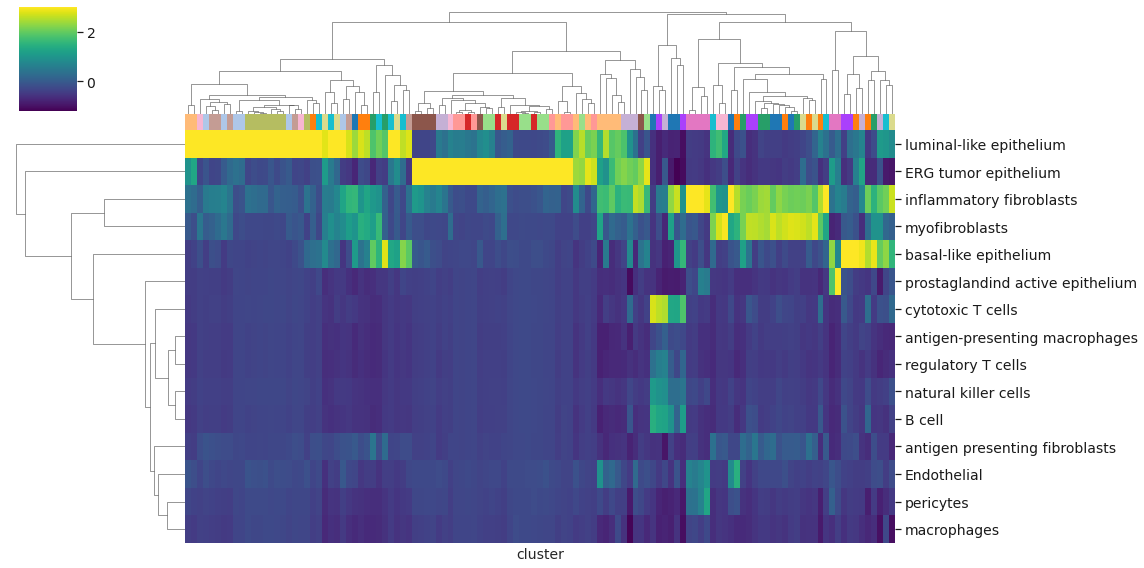

In [25]:
ctype_start = 0
n_ctypes = 15

n_cells_col_cap = 3

# Take 10 most prevalent cell types and use them for the heatmap
heatmap_vars = np.array(cell_mapping_dat.var_names[np.argsort(np.sum(
    cell_mapping_dat.X,axis=0))[::-1]])[ctype_start:ctype_start + n_ctypes]

# Backup for taking specific cell types
# heatmap_vars = [x for x in scaled_cell_mapping_dat.var_names if "epithelial" in x or "fibroblast" in x or "pericyte" in x]


# Convert X and annotations to pandas DataFrame
df = pd.DataFrame(cell_mapping_dat.X)
df['cluster'] = cell_mapping_dat.obs['joint_leiden_clusters'].tolist()
#df['sample_id'] = cell_mapping_dat.obs['sample_id']

# Group rows by their annotation values and calculate the average of each group
averaged_df = df.groupby('cluster').mean()
averaged_df.columns = cell_mapping_dat.var_names

averaged_df = averaged_df[heatmap_vars]

# Extract sample names from index values
sample_names = ['_'.join(index.split("_")[:-1]) for index in averaged_df.index]

# Create a dictionary that maps each sample name to a color
color_map = {sample: sns.color_palette()[i] for i, sample in enumerate(sorted(set(sample_names)))}

# Use the color_map dictionary to assign colors to each index value
colors = [color_map[sample_name] for sample_name in sample_names]

sns.clustermap(averaged_df.T, col_colors=colors, cmap='viridis', z_score=1,
                vmax=n_cells_col_cap, figsize=(16,8), xticklabels=False)


In [ ]:

sc.tl.rank_genes_groups(cell_mapping_dat,groupby='joint_leiden_clusters')
for cl in cell_mapping_dat.obs['joint_leiden_clusters'].cat.categories:
    df = sc.get.rank_genes_groups_df(cell_mapping_dat,group=cl)
    df = df.iloc[np.where(df['logfoldchanges'] > np.quantile(df['logfoldchanges'],0.95))[0]]['names']
    print('Cluster ' + cl  + ' is characterized by these cell types:')
    print(df)
    print('')

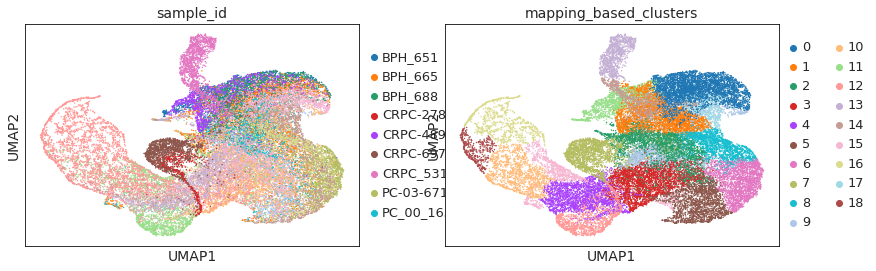

In [26]:

sc.pp.pca(cell_mapping_dat)
sc.pp.neighbors(cell_mapping_dat)
sc.tl.umap(cell_mapping_dat)
sc.tl.leiden(cell_mapping_dat,key_added='mapping_based_clusters', resolution=0.5)

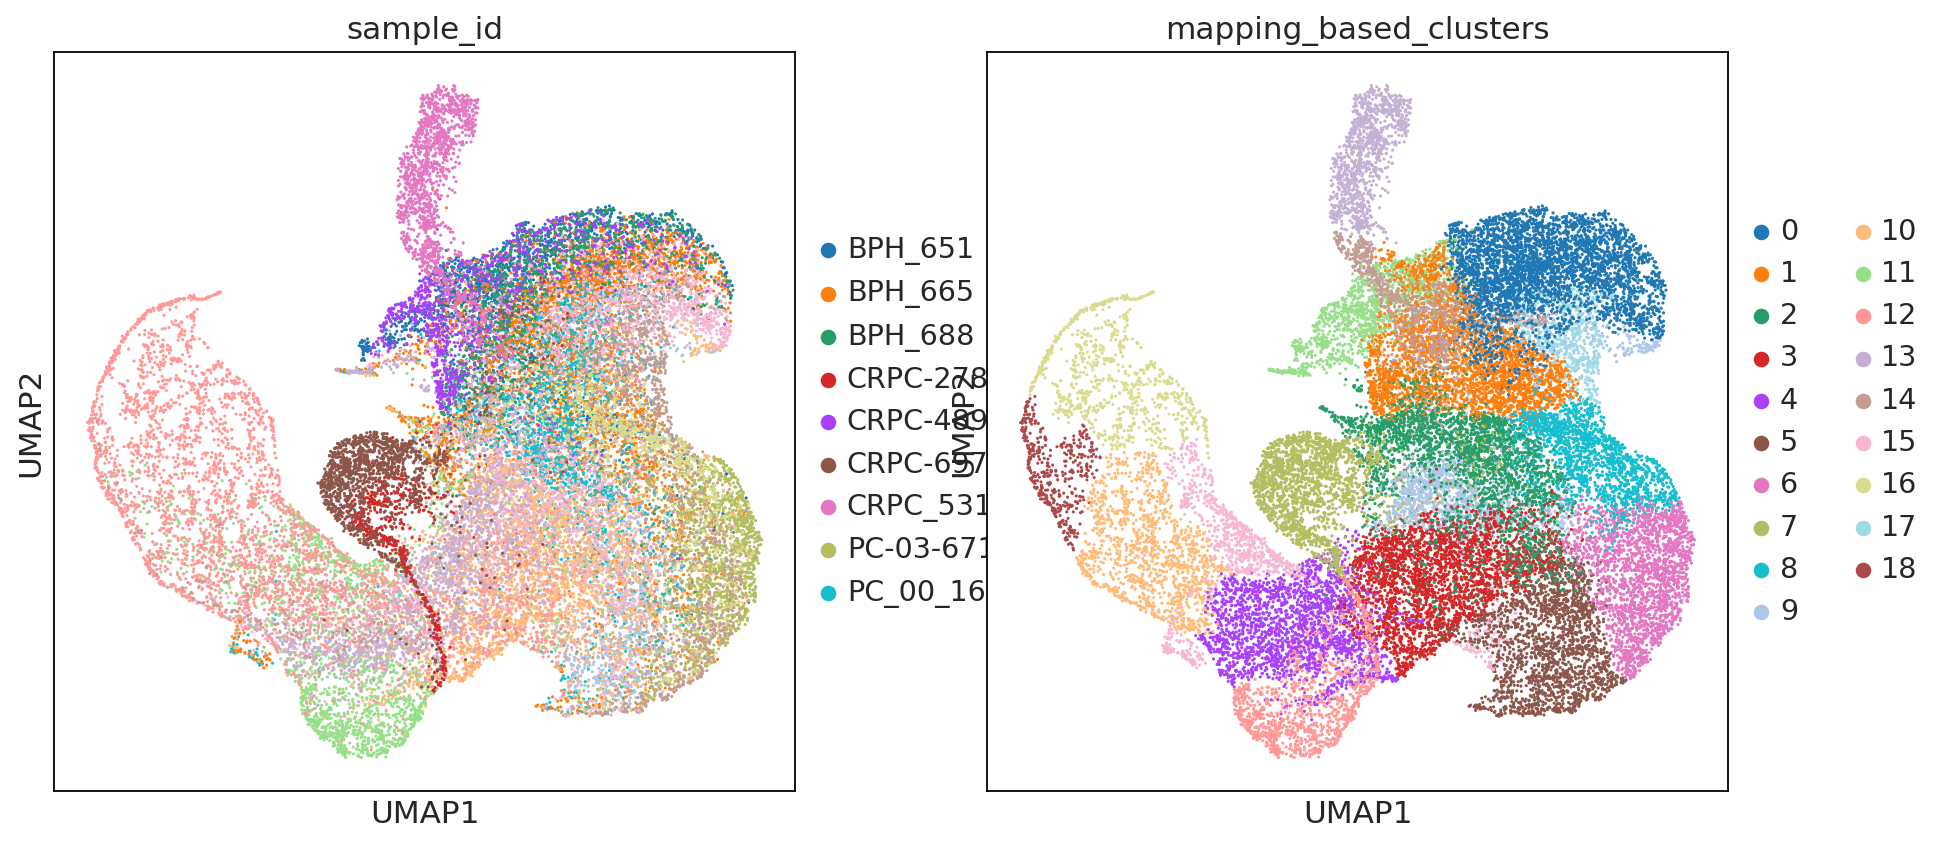

In [27]:
sc.set_figure_params(figsize=(6,6))
sc.pl.umap(cell_mapping_dat,color=['sample_id','mapping_based_clusters'],s = 8)

In [ ]:
sc.set_figure_params(figsize=(4,4),dpi=100,frameon=True,format='pdf')
sc.pl.umap(cell_mapping_dat,color=['early malignant epithelial','pericytes','healthy epithelial'], cmap='viridis',s=6,vmax=20)

In [ ]:
n_cats = len(cell_mapping_dat.obs['mapping_based_clusters'].cat.categories)
final_nhood_enrichment_matrix = np.zeros([n_cats,n_cats])
for sample in samples:
    #Assign the sample from a list and make it the current "slide"
    slide = adata_slides[sample]

    #Check if "mapping_based_clusters" exists in "slide.obs", merge with "cell_mapping_dat.obs" if yes
    if 'mapping_based_clusters' not in slide.obs.columns:
        obs_with_mapping_clusters = pd.merge(slide.obs,cell_mapping_dat.obs[['mapping_based_clusters']],left_index=True,right_index=True)
        if (obs_with_mapping_clusters.index == slide.obs.index).all():
            slide.obs = obs_with_mapping_clusters
            
    #Create the spatial neighborhood graph for the cells in "slide"
    sq.gr.spatial_neighbors(slide)

    #Calculate the enrichment of each cluster defined in "mapping_based_clusters" within its neighboring cells
    sq.gr.nhood_enrichment(slide, cluster_key="mapping_based_clusters")

    slide_nhood_enrichment_matrix = slide.uns['mapping_based_clusters_nhood_enrichment']['zscore'].copy()
    slide_nhood_enrichment_matrix = np.nan_to_num(slide_nhood_enrichment_matrix)
    final_nhood_enrichment_matrix = final_nhood_enrichment_matrix + slide_nhood_enrichment_matrix

#Visualize the results of the neighborhood enrichment analysis
#sq.pl.nhood_enrichment(slide, cluster_key="mapping_based_clusters",title=sample + ' mapping-based cluster neighborhood enrichment')
sns.heatmap(final_nhood_enrichment_matrix, cmap='viridis',vmax = 100 ) # annot=True, fmt=".1f"


In [ ]:
for sample in samples:
    #Assign the sample from a list and make it the current "slide"
    slide = adata_slides[sample]

    #Check if "mapping_based_clusters" exists in "slide.obs", merge with "cell_mapping_dat.obs" if yes
    if 'mapping_based_clusters' not in slide.obs.columns:
        obs_with_mapping_clusters = pd.merge(slide.obs,cell_mapping_dat.obs[['mapping_based_clusters']],left_index=True,right_index=True)
        if (obs_with_mapping_clusters.index == slide.obs.index).all():
            slide.obs = obs_with_mapping_clusters
    
    with mpl.rc_context({'axes.facecolor':  'white',
                    'figure.figsize': [6,6]}):
        fig, ax = plt.subplots(1,1)
        sc.pl.spatial(slide,
                color='mapping_based_clusters',
                size=1.4,alpha_img=0.8,
                show=False,ax = ax
                )
        plt.savefig('./plots/c2l_mapping_results_20230511/'+sample+'_cell_type_mapping_based_clusters.png',dpi=400)
        plt.tight_layout()
        plt.clf()